## Classification model

#### Import all necessary libraries 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    cross_validate,
    KFold,
    StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (
    LinearRegression, 
    Ridge, 
    Lasso,
    LogisticRegression
)
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (
    RandomForestClassifier
)
from imblearn.over_sampling import SMOTE
import pickle
import warnings
import os
from pathlib import Path
warnings.filterwarnings('ignore')
np.random.seed(42)

#### Load data

In [25]:
# Configuration 

REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(REPO_ROOT, "Datasets_all")
OUT_DIR = Path("models")

RANDOM_STATE = 42
N_SPLITS = 5  # 5-fold CV

# Dataset 1: New dataset with Weak link scores with 14 categories
weaklink_scores_df = pd.read_csv(os.path.join(DATA_DIR,"scores_and_weaklink.csv"))

# Dataset 2: Movement features 38 features
movement_features_df = pd.read_csv(os.path.join(DATA_DIR, "aimoscores.csv"))

print("Dataset 1 - Weak Link Scores:")
print(f"Shape: {weaklink_scores_df.shape}")
print("\nFirst few rows:")
print(weaklink_scores_df.head(2))

print("\n\n")

print("Dataset 2 - Movement Features:")
print(f"Shape: {movement_features_df.shape}")
print("\nFirst few rows:")
print(movement_features_df.head(2))

Dataset 1 - Weak Link Scores:
Shape: (2096, 17)

First few rows:
                                            ID       Date     SCORE  \
0  cf0e95ab-d6ec-475a-9cc0-c9444b8dd080.Kinect  7/19/2018  0.612532   
1  6210cc6d-575d-4e9f-bab1-4fe1da2a30a3.Kinect  7/30/2018  0.388809   

   ForwardHead  LeftArmFallForward  RightArmFallForward  \
0         0.31                1.34                 1.15   
1         1.49                1.42                 1.39   

   LeftShoulderElevation  RightShoulderElevation  ExcessiveForwardLean  \
0                   0.33                    0.49                  0.00   
1                   0.00                    0.00                  1.08   

   LeftAsymmetricalWeightShift  RightAsymmetricalWeightShift  \
0                          0.0                          0.08   
1                          0.1                          0.00   

   LeftKneeMovesInward  RightKneeMovesInward  LeftKneeMovesOutward  \
0                  0.0                   0.0             

#### Define weak link categories



Weakest Link Distribution:
WeakestLink
LeftArmFallForward              616
RightArmFallForward             458
RightKneeMovesOutward           274
RightShoulderElevation          245
ExcessiveForwardLean            128
ForwardHead                     109
LeftAsymmetricalWeightShift      80
LeftShoulderElevation            55
LeftKneeMovesOutward             54
RightKneeMovesInward             45
RightAsymmetricalWeightShift     20
LeftHeelRises                     7
LeftKneeMovesInward               3
RightHeelRises                    2
Name: count, dtype: int64


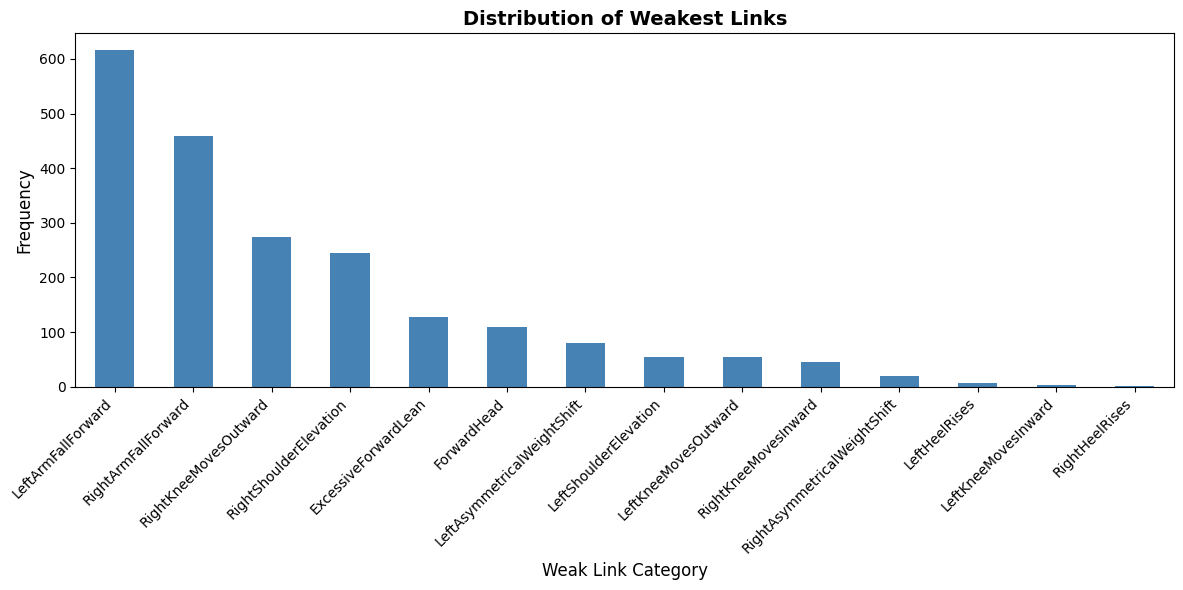

In [26]:
weaklink_categories = [
    "ExcessiveForwardLean",
    "ForwardHead",
    "LeftArmFallForward",
    "LeftAsymmetricalWeightShift",
    "LeftHeelRises",
    "LeftKneeMovesInward",
    "LeftKneeMovesOutward",
    "LeftShoulderElevation",
    "RightArmFallForward",
    "RightAsymmetricalWeightShift",
    "RightHeelRises",
    "RightKneeMovesInward",
    "RightKneeMovesOutward",
    "RightShoulderElevation"
]

# For each row, find the column name with the maximum score
weaklink_scores_df['WeakestLink'] = weaklink_scores_df[weaklink_categories].idxmax(axis=1)

print(f"\nWeakest Link Distribution:")
print(weaklink_scores_df['WeakestLink'].value_counts())

# Visualize the distribution
plt.figure(figsize=(12, 6))
weaklink_scores_df['WeakestLink'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribution of Weakest Links', fontsize=14, fontweight='bold')
plt.xlabel('Weak Link Category', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Merge datasets

In [27]:
target_df = weaklink_scores_df[['ID', 'WeakestLink']].copy()
merged_df = movement_features_df.merge(target_df, on='ID', how='inner')

print(f"Merged dataset: {merged_df.shape}")

Merged dataset: (2094, 44)


#### Body regions 

In [28]:
# Define the groups as mentioned in Slide 6 into 2 distinct regions
upper_body_classes = [
    "ForwardHead",
    "LeftArmFallForward",
    "RightArmFallForward",
    "LeftShoulderElevation",
    "RightShoulderElevation"
]

lower_body_classes = [
    "ExcessiveForwardLean",
    "LeftAsymmetricalWeightShift",
    "RightAsymmetricalWeightShift",
    "LeftKneeMovesInward",
    "RightKneeMovesInward",
    "LeftKneeMovesOutward",
    "RightKneeMovesOutward",
    "LeftHeelRises",
    "RightHeelRises"
]
def get_region(label):
    if label in upper_body_classes:
        return "Upper Body"
    else:
        return "Lower Body"

merged_df['BodyRegion'] = merged_df['WeakestLink'].apply(get_region)

print(f"\nBody region distribution:")
print(merged_df['BodyRegion'].value_counts())


Body region distribution:
BodyRegion
Upper Body    1484
Lower Body     610
Name: count, dtype: int64


#### Prepare features

In [29]:
# Exclude non-features
exclude_from_X = ['ID', 'WeakestLink', 'EstimatedScore', 'BodyRegion']
feature_columns = [col for col in merged_df.columns if col not in exclude_from_X]

X = merged_df[feature_columns].values
y_14class = merged_df['WeakestLink'].values # For predicting specific weak link
y_region = merged_df['BodyRegion'].values # For predicting 2 body region

print(f"Features shape: {X.shape}")
print(f"Number of features: {len(feature_columns)}")
print(f"14-class target: {len(np.unique(y_14class))} classes")
print(f"Region target: {len(np.unique(y_region))} classes")

Features shape: (2094, 41)
Number of features: 41
14-class target: 14 classes
Region target: 2 classes


#### Train/test split

In [30]:
# Same random split for all X, y_14class and y_Region
X_train, X_test, y_train_14, y_test_14, y_train_region, y_test_region = train_test_split(
    X, y_14class, y_region, test_size=0.2, random_state=RANDOM_STATE, stratify=y_region
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 1675 samples
Test set: 419 samples


#### Cross validation setup

In [31]:
# Body region (upper and lower) with cross validation

cv_strategy = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
def evaluate_classification_cv(model, X, y, cv, model_name="Model"):
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }
    
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    return {
        'Model': model_name,
        'Accuracy_mean': cv_results['test_accuracy'].mean(),
        'Accuracy_std': cv_results['test_accuracy'].std(),
        'Precision_mean': cv_results['test_precision'].mean(),
        'Precision_std': cv_results['test_precision'].std(),
        'Recall_mean': cv_results['test_recall'].mean(),
        'Recall_std': cv_results['test_recall'].std(),
        'F1_mean': cv_results['test_f1'].mean(),
        'F1_std': cv_results['test_f1'].std()
    }, cv_results['test_f1']


In [32]:
# Define models for region classification
models_region = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'KNN (k=10)': KNeighborsClassifier(n_neighbors=10)
}

results_region = []
f1_scores_region_dict = {}

for name, model in models_region.items():
    result, f1_scores = evaluate_classification_cv(model, X_train_scaled, y_train_region, cv_strategy, name)
    results_region.append(result)
    f1_scores_region_dict[name] = f1_scores

results_region_df = pd.DataFrame(results_region).sort_values('F1_mean', ascending=False)

In [33]:
print("Body region (upper and lower) results of 5-FOLD CV")
print("\n")
print(results_region_df[['Model', 'Accuracy_mean', 'Accuracy_std', 'F1_mean', 'F1_std']].to_string(index=False))

champion_region = results_region_df.iloc[0]['Model']
champion_region_f1 = results_region_df.iloc[0]['F1_mean']

print(f"\nChampion (Stage 1): {champion_region}")
print(f"F1-Score: {champion_region_f1:.4f} +/- {results_region_df.iloc[0]['F1_std']:.4f}")

Body region (upper and lower) results of 5-FOLD CV


              Model  Accuracy_mean  Accuracy_std  F1_mean   F1_std
          KNN (k=7)       0.854925      0.010096 0.848728 0.009112
         KNN (k=10)       0.847761      0.012089 0.842864 0.011621
          KNN (k=5)       0.846567      0.011264 0.841796 0.009819
                LDA       0.845970      0.022065 0.841575 0.022885
Logistic Regression       0.826866      0.023656 0.831218 0.022478
        Naive Bayes       0.786866      0.008142 0.786612 0.008865
                QDA       0.592239      0.104172 0.593148 0.117567

Champion (Stage 1): KNN (k=7)
F1-Score: 0.8487 +/- 0.0091


In [34]:
# 14 weak link categories classification with cross validation
models_14class = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'KNN (k=10)': KNeighborsClassifier(n_neighbors=10)
}
results_14class = []
f1_scores_14class_dict = {}

for name, model in models_14class.items():
    try:
        result, f1_scores = evaluate_classification_cv(model, X_train_scaled, y_train_14, cv_strategy, name)
        results_14class.append(result)
        f1_scores_14class_dict[name] = f1_scores
    except Exception as e:
        print(f"failed: {e}")

results_14class_df = pd.DataFrame(results_14class).sort_values('F1_mean', ascending=False)

In [35]:
print("14 weak link categories with 5 -fold cross validation")
print("\n")
print(results_14class_df[['Model', 'Accuracy_mean', 'Accuracy_std', 'F1_mean', 'F1_std']].to_string(index=False))

champion_14class = results_14class_df.iloc[0]['Model']
champion_14class_f1 = results_14class_df.iloc[0]['F1_mean']

print(f"\nChampion (Single Model): {champion_14class}")
print(f"F1-Score: {champion_14class_f1:.4f} +/- {results_14class_df.iloc[0]['F1_std']:.4f}")

14 weak link categories with 5 -fold cross validation


              Model  Accuracy_mean  Accuracy_std  F1_mean   F1_std
                LDA       0.576716      0.023076 0.575048 0.020004
Logistic Regression       0.531343      0.022812 0.543853 0.019283
         KNN (k=10)       0.564179      0.011940 0.543014 0.011788
          KNN (k=7)       0.548060      0.016631 0.533035 0.019749
          KNN (k=5)       0.536119      0.016631 0.523832 0.018366
        Naive Bayes       0.470448      0.019123 0.484504 0.013492

Champion (Single Model): LDA
F1-Score: 0.5750 +/- 0.0200


###  Improvements (as per A3 comments)

### Predicting specific region and then train on specific region

In [36]:
def evaluate_hierarchical_pipeline_cv(X, y_14class, y_region, cv, 
                                       stage1_model_class, stage2_model_class):
    f1_scores = []
    
    for train_idx, test_idx in cv.split(X, y_region):
        # Split data
        X_train_fold = X[train_idx]
        X_test_fold = X[test_idx]
        y_train_14_fold = y_14class[train_idx]
        y_test_14_fold = y_14class[test_idx]
        y_train_region_fold = y_region[train_idx]
        
        # Stage 1: Train region classifier
        stage1 = stage1_model_class()
        stage1.fit(X_train_fold, y_train_region_fold)
        
        # Stage 2a: Train upper body 
        upper_mask = y_train_region_fold == "Upper Body"
        X_train_upper = X_train_fold[upper_mask]
        y_train_upper = y_train_14_fold[upper_mask]
        
        stage2a = stage2_model_class()
        stage2a.fit(X_train_upper, y_train_upper)
        
        # Stage 2b: Train lower body 
        lower_mask = y_train_region_fold == "Lower Body"
        X_train_lower = X_train_fold[lower_mask]
        y_train_lower = y_train_14_fold[lower_mask]
        
        stage2b = stage2_model_class()
        stage2b.fit(X_train_lower, y_train_lower)
        
        # Predict on test fold
        y_pred = []
        for i in range(len(X_test_fold)):
            x_sample = X_test_fold[i].reshape(1, -1)
            
            # Stage 1: Predict region
            region = stage1.predict(x_sample)[0]
            
            # Stage 2: Predict specific weak link
            if region == "Upper Body":
                weak_link = stage2a.predict(x_sample)[0]
            else:
                weak_link = stage2b.predict(x_sample)[0]
            
            y_pred.append(weak_link)
        
        # Compute F1-score
        f1 = f1_score(y_test_14_fold, y_pred, average='weighted', zero_division=0)
        f1_scores.append(f1)
    
    return np.array(f1_scores)

In [ ]:
# Use best models from previous evaluations
stage1_model = lambda: KNeighborsClassifier(n_neighbors=7)  # Best region classifier
stage2_model = lambda: LinearDiscriminantAnalysis()

pipeline_f1_scores = evaluate_hierarchical_pipeline_cv(
    X_train_scaled, y_train_14, y_train_region, cv_strategy,
    stage1_model, stage2_model
)

In [ ]:
print("Comparison of Pipeline vs single model")

print(f"\nSingle Model ({champion_14class}):")
print(f"F1-Score: {champion_14class_f1:.4f} +/- {results_14class_df.iloc[0]['F1_std']:.4f}")

print(f"\nHierarchical Pipeline:")
print(f"F1-Score: {pipeline_f1_scores.mean():.4f} +/- {pipeline_f1_scores.std():.4f}")

improvement = pipeline_f1_scores.mean() - champion_14class_f1
print(f"\nDifference: {improvement:+.4f} ({100*improvement/champion_14class_f1:+.2f}%)")

### Statistical test

In [ ]:
def corrected_resampled_ttest(scores_a, scores_b, n_train, n_test):
    k = len(scores_a)
    differences = scores_a - scores_b
    d_bar = differences.mean()
    s_squared = differences.var(ddof=1)
    var_corrected = (1/k + n_test/n_train) * s_squared
    t_stat = d_bar / np.sqrt(var_corrected)
    df = k - 1
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))
    return t_stat, p_value

n_total = len(X_train_scaled)
n_test_fold = n_total // N_SPLITS
n_train_fold = n_total - n_test_fold

champion_14class_scores = f1_scores_14class_dict[champion_14class]
t_stat, p_value = corrected_resampled_ttest(pipeline_f1_scores, champion_14class_scores, n_train_fold, n_test_fold)

print(f"\nStatistical Test (Corrected Resampled t-test):")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print(f" Result: Statistically SIGNIFICANT difference")
else:
    print(f"Result: NOT statistically significant")

## - 54.47% chance this difference occurred by random chance
# Cannot reject null hypothesis (no significant difference)
# Pipeline is NOT reliably better than single LDA

# determine if there is a significant difference between the means (averages) of two groups, or between one group and a known standard value. 
    #It calculates a 
# statistic to assess whether observed differences between sample averages are likely due to real effects or just random chance

### Visualization

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

models = [f'Single Model\n({champion_14class})', 'Hierarchical\nPipeline']
means = [champion_14class_f1, pipeline_f1_scores.mean()]
stds = [results_14class_df.iloc[0]['F1_std'], pipeline_f1_scores.std()]

bars = ax.bar(models, means, yerr=stds, capsize=10, 
              color=['lightcoral', 'lightblue'], edgecolor='black', linewidth=2)
ax.set_ylabel('F1-Score (weighted)', fontsize=12, fontweight='bold')
ax.set_title('Hierarchical Pipeline vs Single Model\n14-Class Weak Link Classification',
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
            f'{mean:.4f}+/-{std:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
print("Final moodel training")

if pipeline_f1_scores.mean() > champion_14class_f1 and p_value < 0.05:
    print("\nTraining the pipeline model on full training set")
    
    # Train Stage 1
    final_stage1 = KNeighborsClassifier(n_neighbors=7)
    final_stage1.fit(X_train_scaled, y_train_region)
    
    # Train Stage 2a (Upper region)
    upper_mask_train = y_train_region == "Upper Body"
    final_stage2a = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced')
    final_stage2a.fit(X_train_scaled[upper_mask_train], y_train_14[upper_mask_train])
    
    # Train Stage 2b (Lower region)
    lower_mask_train = y_train_region == "Lower Body"
    final_stage2b = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced')
    final_stage2b.fit(X_train_scaled[lower_mask_train], y_train_14[lower_mask_train])
    
    # Test set evaluation
    y_pred_test = []
    for i in range(len(X_test_scaled)):
        x_sample = X_test_scaled[i].reshape(1, -1)
        region = final_stage1.predict(x_sample)[0]
        if region == "Upper Body":
            weak_link = final_stage2a.predict(x_sample)[0]
        else:
            weak_link = final_stage2b.predict(x_sample)[0]
        y_pred_test.append(weak_link)
    
    test_f1 = f1_score(y_test_14, y_pred_test, average='weighted')
    test_acc = accuracy_score(y_test_14, y_pred_test)
    
    print(f"\nTest Set Performance (Hierarchical Pipeline):")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"F1-Score: {test_f1:.4f}")
    
    # Save pipeline
    final_model = {
        'type': 'hierarchical_pipeline',
        'stage1': final_stage1,
        'stage2a': final_stage2a,
        'stage2b': final_stage2b,
        'scaler': scaler,
        'feature_columns': feature_columns,
        'upper_classes': upper_body_classes,
        'lower_classes': lower_body_classes
    }
    
else:
    print(f"\nTraining the single model ({champion_14class}) on full training set")
    
    # Train single model
    if champion_14class == 'Logistic Regression':
        final_model_obj = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced')
    elif champion_14class == 'LDA':
        final_model_obj = LinearDiscriminantAnalysis()
    elif 'KNN' in champion_14class:
        k = int(champion_14class.split('k=')[1].rstrip(')'))
        final_model_obj = KNeighborsClassifier(n_neighbors=k)
    else:
        final_model_obj = GaussianNB()
    
    final_model_obj.fit(X_train_scaled, y_train_14)
    
    # Test set evaluation
    y_pred_test = final_model_obj.predict(X_test_scaled)
    test_f1 = f1_score(y_test_14, y_pred_test, average='weighted')
    test_acc = accuracy_score(y_test_14, y_pred_test)
    
    print(f"\nTest Set Performance ({champion_14class}):")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"F1-Score: {test_f1:.4f}")
    
    final_model = {
        'type': 'single_model',
        'model': final_model_obj,
        'scaler': scaler,
        'feature_columns': feature_columns
    }

### Classification report

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test_14, y_pred_test, zero_division=0))

### Class imbalance analysis - Using Random forest


In [ ]:

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,           # 200 decision trees
    max_depth=15,               # Max tree depth
    min_samples_split=5,        
    min_samples_leaf=2,         
    class_weight='balanced',    
    random_state=RANDOM_STATE,
    n_jobs=-1                  
)

rf_model.fit(X_train_scaled, y_train_14)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate
rf_f1 = f1_score(y_test_14, y_pred_rf, average='weighted')
rf_acc = accuracy_score(y_test_14, y_pred_rf)
rf_precision = precision_score(y_test_14, y_pred_rf, average='weighted', zero_division=0)
rf_recall = recall_score(y_test_14, y_pred_rf, average='weighted', zero_division=0)

print(f"\nRandom Forest trained with {rf_model.n_estimators} trees")
print(f"\nTest Set Performance:")
print(f"Accuracy:  {rf_acc:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")

print(f"\nComparison to baselines:")
print(f"Baseline (LDA):        F1 = 0.5750")
print(f"Baseline (Pipeline):   F1 = 0.5473")
print(f"Random Forest:         F1 = {rf_f1:.4f}")
improvement_vs_lda = ((rf_f1 - 0.5750) / 0.5750) * 100
print(f"Improvement vs LDA:    {improvement_vs_lda:+.2f}%")

### Final comparison

In [ ]:


# Collect all results
results_all = [
    {'Approach': 'Baseline - LDA (Lab 3)', 
     'F1-Score': 0.5750}, 
    
    {'Approach': 'Hierarchical Pipeline', 
     'F1-Score': 0.5473},
    
    {'Approach': 'Random Forest', 
     'F1-Score': rf_f1},
]

# Create DataFrame and sort
results_comparison_df = pd.DataFrame(results_all)
results_comparison_df = results_comparison_df.sort_values('F1-Score', ascending=False)

print("\n")
print(results_comparison_df.to_string(index=False))

# Identify best approach
best_approach = results_comparison_df.iloc[0]
baseline_f1 = 0.5750


print(f"Model: {best_approach['Approach']}")
print(f"F1-Score: {best_approach['F1-Score']:.4f}")
print(f"Improvement over baseline: {((best_approach['F1-Score'] - baseline_f1) / baseline_f1 * 100):+.2f}%")

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))

approaches = results_comparison_df['Approach']
f1_scores = results_comparison_df['F1-Score']

bars = ax.barh(approaches, f1_scores, color='skyblue', edgecolor='black', linewidth=1.5)

# Color best bar gold
bars[0].set_color('gold')
bars[0].set_edgecolor('darkgoldenrod')
bars[0].set_linewidth=2

# Add baseline reference line
ax.axvline(0.5750, color='red', linestyle='--', linewidth=2, 
           label='Original Baseline (LDA = 0.575)', alpha=0.7)

ax.set_xlabel('F1-Score (weighted)', fontsize=12, fontweight='bold')
ax.set_title('Comparison of All Classification Approaches\n14-Class Weak Link Prediction', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim([0.5, 0.7])

# Add value labels
for bar, score in zip(bars, f1_scores):
    ax.text(score + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{score:.4f}',
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Detailed analysis of the champion model

if best_approach['Approach'] == 'Random Forest':
    best_model = rf_model
    best_predictions = y_pred_rf
else:
    best_model = None
    best_predictions = y_pred_rf

print(f"\nClassification Report for: {best_approach['Approach']}")
print(classification_report(y_test_14, best_predictions, zero_division=0))


In [ ]:
# Prepare the final model package
final_model_package = {
    'model_type': 'Random Forest',
    'model': rf_model,
    'scaler': scaler,
    'feature_columns': feature_columns,
    'classes': list(rf_model.classes_),
    'weaklink_categories': weaklink_categories,
    'upper_body_classes': upper_body_classes,
    'lower_body_classes': lower_body_classes,
    'test_performance': {
        'accuracy': rf_acc,
        'precision': rf_precision,
        'recall': rf_recall,
        'f1_score': rf_f1
    },
    'training_info': {
        'n_estimators': rf_model.n_estimators,
        'max_depth': rf_model.max_depth,
        'random_state': RANDOM_STATE,
        'training_samples': X_train.shape[0],
        'test_samples': X_test.shape[0],
        'n_features': len(feature_columns)
    }
}

# Save to pickle file
model_path = OUT_DIR / 'weaklink_classifier_rf.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model_package, f)